## DDQN in Simpler Environments

Base DQN implementation adapted from HW7

In [1]:
import os
import sys
from importlib import reload

import numpy as np
import gymnasium as gym
import torch
from gymnasium import spaces
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

# Adding the parent directory to the path to enable importing
root_dir = os.path.dirname(os.path.abspath("../"))
if root_dir not in sys.path:
    sys.path.append(root_dir)
    
import DDQN as ddqn
from DDQN.DQN import DQNAgent, TargetDQNAgent, DoubleDQNAgent
from DDQN.DDQN import DuelingDQNAgent, DoubleDuelingDQNAgent

reload(ddqn)

<module 'DDQN' from '/home/kivanc/ders/RL/project/RL-Hockey/DDQN/__init__.py'>

In [ ]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)


class DiscreteActionWrapper(gym.ActionWrapper):
    def __init__(self, env: gym.Env, bins = 5):
        """A wrapper for converting a 1D continuous actions into discrete ones.
        Args:
            env: The environment to apply the wrapper
            bins: number of discrete actions
        """
        assert isinstance(env.action_space, spaces.Box)
        super().__init__(env)
        self.bins = bins
        self.orig_action_space = env.action_space
        self.action_space = spaces.Discrete(self.bins)

    def action(self, action):
        """ discrete actions from low to high in 'bins'
        Args:
            action: The discrete action
        Returns:
            continuous action
        """
        return self.orig_action_space.low + \
            (action/(self.bins-1.0))*(self.orig_action_space.high-self.orig_action_space.low)


def create_env(env_name, render=False, discrete_wrapper=None):
    if render:
        env = gym.make(env_name, render_mode='human')
    else:
        env = gym.make(env_name)

    if isinstance(env.action_space, spaces.Box):
        env = (DiscreteActionWrapper(env, 5) if discrete_wrapper is None else discrete_wrapper)

    ac_space = env.action_space
    o_space = env.observation_space
    print("Env. action space:")
    print(ac_space)
    print("Env. observation space:")
    print(o_space)
    #print(list(zip(env.observation_space.low, env.observation_space.high)))

    return env, ac_space, o_space


def train_dqn(q_agent, env, iter_fit=32, max_episodes=600, max_steps=500, print_freq=100):
    stats = []
    losses = []

    for i in tqdm(range(max_episodes)):
        # print("Starting a new episode")
        total_reward = 0
        ob, _info = env.reset()
        for t in range(max_steps):
            done = False
            a = q_agent.act(ob)
            (ob_next, reward, done, trunc, _info) = env.step(a)
            total_reward += reward

            q_agent.store_transition((ob, a, reward, ob_next, done))
            ob = ob_next

            #if done or trunc:
            if done:
                break

        loss = q_agent.train(iter_fit)
        losses.extend(loss)
        stats.append([i, total_reward, t+1])
        
        if i % print_freq == 0:
            print("{}: Done after {} steps. Reward: {}".format(i+1, t+1, total_reward))

    return stats, losses

def train_dqn_torch(q_agent, env, iter_fit=32, max_episodes=600, max_steps=500, print_freq=100):
    stats = []
    losses = []

    train_device = q_agent.train_device
    print("Cuda availability:", torch.cuda.is_available())
    print("Training on device:", train_device)

    def np2gpu(data: np.ndarray) -> torch.Tensor:
        return torch.from_numpy(data).to(train_device)

    for i in tqdm(range(max_episodes)):
        # print("Starting a new episode")
        total_reward = 0
        ob, _info = env.reset()
        for t in range(max_steps):
            done = False
            a = q_agent.act_torch(np2gpu(ob))
            (ob_next, reward, done, trunc, _info) = env.step(a)
            total_reward += reward

            q_agent.store_transition((ob, a, reward, ob_next, done))
            ob = ob_next

            #if done or trunc:
            if done:
                break

        loss = q_agent.train_torch(iter_fit)
        losses.extend(loss)
        stats.append([i, total_reward, t+1])
        
        if i % print_freq == 0:
            print("{}: Done after {} steps. Reward: {}".format(i+1, t+1, total_reward))

    return stats, losses


def plot_training(stats, losses):
    stats_np = np.asarray(stats)
    losses_np = np.asarray(losses)

    plt.figure(figsize=(6, 3.8))
    plt.plot(stats_np[:, 1], label="return")
    plt.plot(running_mean(stats_np[:, 1], 20), label="smoothed-return")
    plt.legend()

    plt.figure(figsize=(6, 3.8))
    plt.plot(losses_np, label="loss")
    #plt.plot(running_mean(losses_np, 20), label="smoothed-loss")
    plt.legend()


def display_env(q_agent, env):
    """Display trained agent's performance. Human-mode rendering recommended for demonstration."""

    ob, _info = env.reset()
    if isinstance(env.action_space, spaces.Box):
        env = DiscreteActionWrapper(env,5)

    env.reset()
    total_reward = 0
    for t in range(500):
        a = q_agent.act(ob)
        (ob, reward, done, trunc, _info) = env.step(a)
        total_reward+= reward
        if done or trunc: break

    print("Total reward:", total_reward)

## On CPU

### DQN

#### Pendulum

In [3]:
env, ac_space, o_space = create_env("Pendulum-v1")

q_agent = DQNAgent(
    o_space,
    ac_space,
    discount=0.95,
    eps=0.2
)

stats, losses = train_dqn(q_agent, env, max_episodes=1000, max_steps=500, print_freq=100)

env.close()

Env. action space:
Discrete(5)
Env. observation space:
Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)


  0%|          | 0/1000 [00:00<?, ?it/s]

1: Done after 500 steps. Reward: -4198.507121845221
101: Done after 500 steps. Reward: -2184.5965141327824
201: Done after 500 steps. Reward: -1400.3974511811525
301: Done after 500 steps. Reward: -511.9593894272363
401: Done after 500 steps. Reward: -136.2799501786518
501: Done after 500 steps. Reward: -260.4804057990078
601: Done after 500 steps. Reward: -392.7939445978647
701: Done after 500 steps. Reward: -372.8359522098342
801: Done after 500 steps. Reward: -482.76012072295254
901: Done after 500 steps. Reward: -378.25684333238826


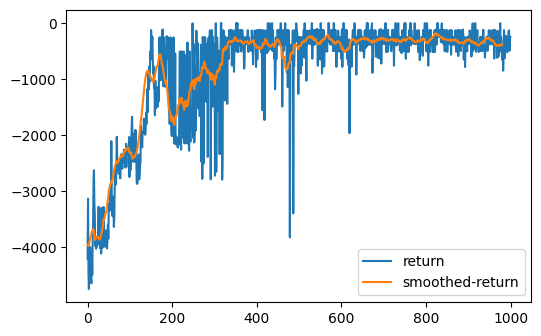

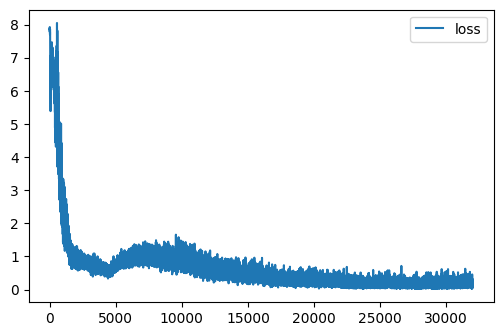

In [4]:
plot_training(stats, losses)

In [5]:
# Display trained agent's performance
env = gym.make("Pendulum-v1", render_mode='human')

display_env(q_agent, env)
env.close()

Total reward: -251.75538461502077


#### LunarLander

In [6]:
env, ac_space, o_space = create_env("LunarLander-v3")

q_agent = DQNAgent(
    o_space,
    ac_space,
    discount=0.95,
    eps=0.2
)

stats, losses = train_dqn(q_agent, env, max_episodes=1000, max_steps=600, print_freq=100)

env.close()

Env. action space:
Discrete(4)
Env. observation space:
Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)


  0%|          | 0/1000 [00:00<?, ?it/s]

1: Done after 89 steps. Reward: -351.19806532515156
101: Done after 600 steps. Reward: 22.662768235732972
201: Done after 600 steps. Reward: 8.87825816066298
301: Done after 600 steps. Reward: 32.923970176111474
401: Done after 600 steps. Reward: 22.54588353024726
501: Done after 600 steps. Reward: -34.78908042800772
601: Done after 600 steps. Reward: 15.002783259061026
701: Done after 600 steps. Reward: 38.29902713930898
801: Done after 600 steps. Reward: 79.89606893294201
901: Done after 600 steps. Reward: 4.016022723165084


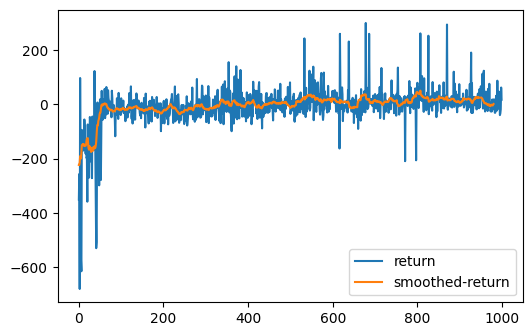

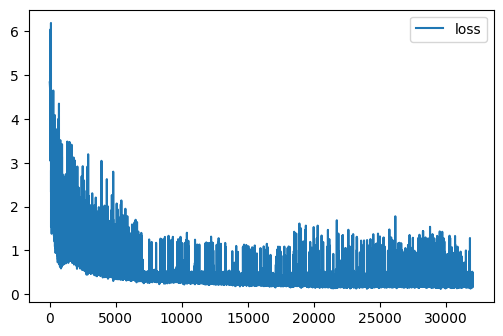

In [7]:
plot_training(stats, losses)

In [8]:
# Display trained agent's performance
env = gym.make("LunarLander-v3", render_mode='human')

display_env(q_agent, env)
env.close()

Total reward: 46.40341948958358


### DQN with Target Network

#### Pendulum

In [9]:
env, ac_space, o_space = create_env("Pendulum-v1")

q_agent = TargetDQNAgent(
    o_space,
    ac_space,
    discount=0.95,
    eps=0.2,
    update_target_every=20,
    tau=1e-3
)

stats, losses = train_dqn(q_agent, env, max_episodes=1000, max_steps=500, print_freq=100)

env.close()

Env. action space:
Discrete(5)
Env. observation space:
Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)


  0%|          | 0/1000 [00:00<?, ?it/s]

1: Done after 500 steps. Reward: -3621.5230440393993
101: Done after 500 steps. Reward: -2706.6422297415484
201: Done after 500 steps. Reward: -2272.354781706714
301: Done after 500 steps. Reward: -134.3032766612123
401: Done after 500 steps. Reward: -386.1240697277579
501: Done after 500 steps. Reward: -1028.292662622233
601: Done after 500 steps. Reward: -255.51477388562017
701: Done after 500 steps. Reward: -128.78955143874046
801: Done after 500 steps. Reward: -125.6957236768407
901: Done after 500 steps. Reward: -7.618507971478466


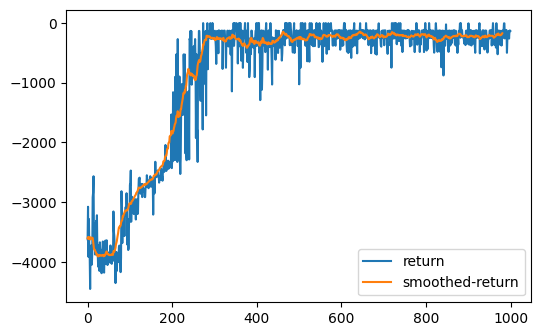

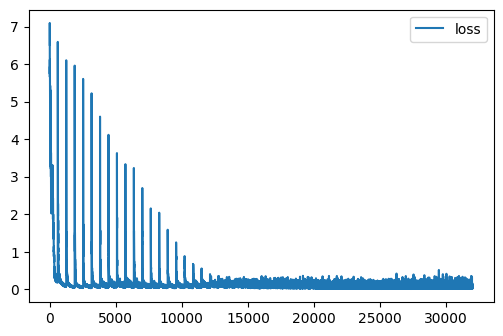

In [10]:
plot_training(stats, losses)

In [11]:
# Display trained agent's performance
env = gym.make("Pendulum-v1", render_mode='human')

display_env(q_agent, env)
env.close()

Total reward: -131.43665402632735


#### LunarLander

In [12]:
env, ac_space, o_space = create_env("LunarLander-v3")

q_agent = TargetDQNAgent(
    o_space,
    ac_space,
    discount=0.95,
    eps=0.2,
    update_target_every=20,
    tau=1e-3
)

stats, losses = train_dqn(q_agent, env, max_episodes=1000, max_steps=600, print_freq=100)

env.close()

Env. action space:
Discrete(4)
Env. observation space:
Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)


  0%|          | 0/1000 [00:00<?, ?it/s]

1: Done after 52 steps. Reward: -376.3980745116087
101: Done after 317 steps. Reward: -181.03784233865457
201: Done after 600 steps. Reward: -5.783303563684454
301: Done after 600 steps. Reward: -25.5845825829805
401: Done after 600 steps. Reward: 112.38679954851888
501: Done after 600 steps. Reward: 6.443143401714194
601: Done after 600 steps. Reward: -24.067510696412103
701: Done after 600 steps. Reward: -17.018678653871646
801: Done after 600 steps. Reward: -12.052848197682476
901: Done after 600 steps. Reward: -0.11264290615019945


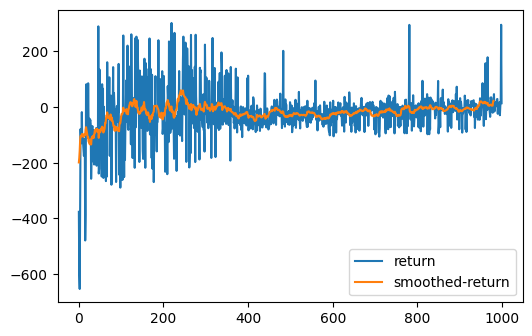

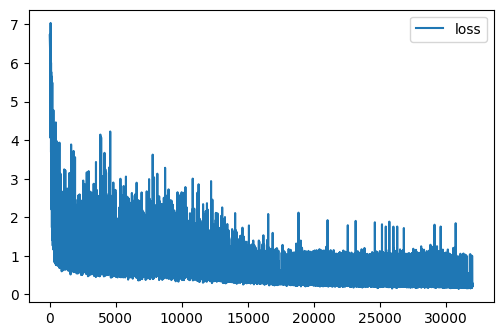

In [13]:
plot_training(stats, losses)

In [14]:
# Display trained agent's performance
env = gym.make("LunarLander-v3", render_mode='human')

display_env(q_agent, env)
env.close()

Total reward: -0.8667135410570552


### Double DQN

#### Pendulum

In [41]:
env, ac_space, o_space = create_env("Pendulum-v1")

q_agent = DoubleDQNAgent(
    o_space,
    ac_space,
    discount=0.95,
    eps=0.2,
    update_target_every=20,
    tau=1e-3
)

stats, losses = train_dqn(q_agent, env, max_episodes=1000, max_steps=500, print_freq=100)

env.close()

Env. action space:
Discrete(5)
Env. observation space:
Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)


  0%|          | 0/1000 [00:00<?, ?it/s]

1: Done after 500 steps. Reward: -4296.6381581218675
101: Done after 500 steps. Reward: -3143.6558275061348
201: Done after 500 steps. Reward: -2434.096302489933
301: Done after 500 steps. Reward: -410.52307707312025
401: Done after 500 steps. Reward: -375.26699412908795
501: Done after 500 steps. Reward: -264.57365592291154
601: Done after 500 steps. Reward: -238.86897116118752
701: Done after 500 steps. Reward: -131.46655392531144
801: Done after 500 steps. Reward: -254.40511029576643
901: Done after 500 steps. Reward: -249.67231488355858


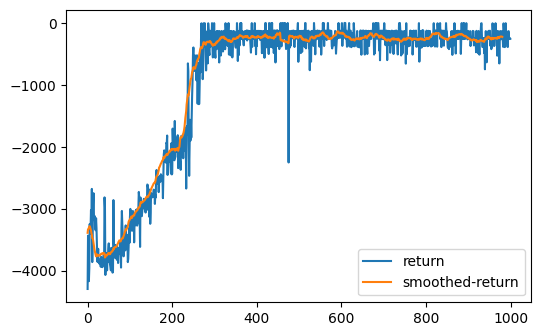

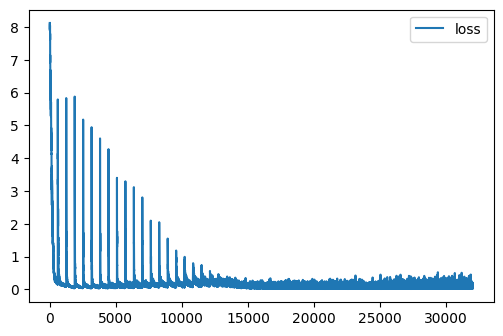

In [42]:
plot_training(stats, losses)

In [17]:
# Display trained agent's performance
env = gym.make("Pendulum-v1", render_mode='human')

display_env(q_agent, env)
env.close()

Total reward: -1.3371193200395561


#### LunarLander

In [18]:
env, ac_space, o_space = create_env("LunarLander-v3")

q_agent = DoubleDQNAgent(
    o_space,
    ac_space,
    discount=0.95,
    eps=0.2,
    update_target_every=20,
    tau=1e-3
)

stats, losses = train_dqn(q_agent, env, max_episodes=1000, max_steps=600, print_freq=100)

env.close()

Env. action space:
Discrete(4)
Env. observation space:
Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)


  0%|          | 0/1000 [00:00<?, ?it/s]

1: Done after 145 steps. Reward: -495.3240614031994
101: Done after 340 steps. Reward: -9.425086161936704
201: Done after 496 steps. Reward: -80.83174452950064
301: Done after 600 steps. Reward: -12.305319161724247
401: Done after 600 steps. Reward: 29.427642697255457
501: Done after 600 steps. Reward: 1.01837006923743
601: Done after 600 steps. Reward: -21.453415646666294
701: Done after 600 steps. Reward: -8.190598129638786
801: Done after 600 steps. Reward: -11.337033903808491
901: Done after 600 steps. Reward: 12.84404326592461


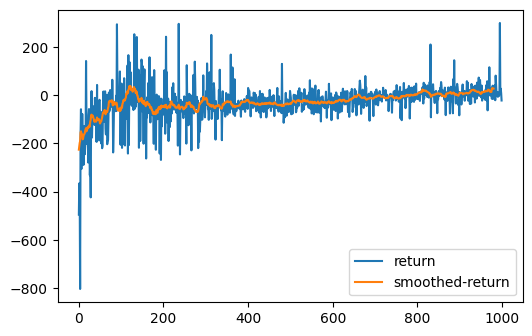

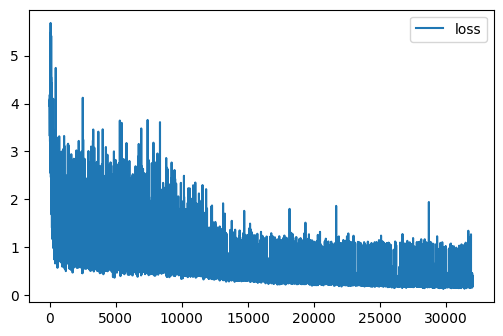

In [19]:
plot_training(stats, losses)

In [20]:
# Display trained agent's performance
env = gym.make("LunarLander-v3", render_mode='human')

display_env(q_agent, env)
env.close()

Total reward: 28.743242150052822


#### Pendulum

In [ ]:
env, ac_space, o_space = create_env("Pendulum-v1")

q_agent = DuelingDQNAgent(
    o_space,
    ac_space,
    discount=0.95,
    eps=0.2,
    update_target_every=20,
    tau=1e-3
)
stats, losses = train_dqn(q_agent, env, max_episodes=1000, max_steps=500, print_freq=100)
env.close()

In [ ]:
plot_training(stats, losses)

In [ ]:
# Display trained agent's performance
env = gym.make("Pendulum-v1", render_mode='human')

display_env(q_agent, env)
env.close()

#### LunarLander

In [ ]:
env, ac_space, o_space = create_env("LunarLander-v3")

q_agent = DuelingDQNAgent(
    o_space,
    ac_space,
    discount=0.95,
    eps=0.2,
    update_target_every=20,
    tau=1e-3
)

stats, losses = train_dqn(q_agent, env, max_episodes=1000, max_steps=600, print_freq=100)

env.close()

In [ ]:
plot_training(stats, losses)

In [ ]:
# Display trained agent's performance
env = gym.make("LunarLander-v3", render_mode='human')

display_env(q_agent, env)
env.close()

## On GPU

### DQN

#### Pendulum

In [ ]:
env, ac_space, o_space = create_env("Pendulum-v1")

q_agent = DQNAgent(
    o_space,
    ac_space,
    discount=0.95,
    eps=0.2,
    use_torch=True
)

stats, losses = train_dqn_torch(q_agent, env, max_episodes=1000, max_steps=500, print_freq=100)

env.close()

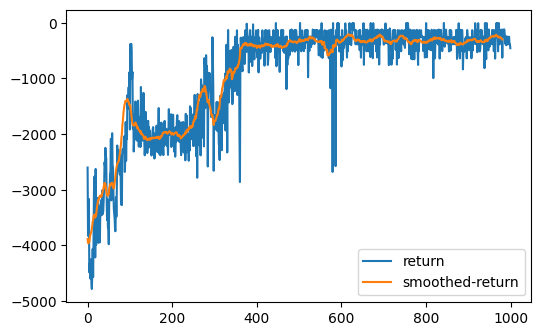

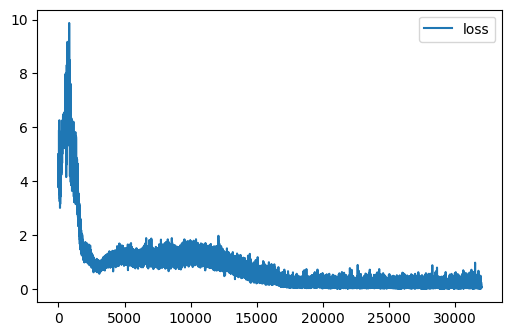

In [24]:
plot_training(stats, losses)

In [25]:
# Display trained agent's performance
env = gym.make("Pendulum-v1", render_mode='human')

display_env(q_agent, env)
env.close()

Total reward: -117.88598528945718


#### LunarLander

In [ ]:
env, ac_space, o_space = create_env("LunarLander-v3")

q_agent = DQNAgent(
    o_space,
    ac_space,
    discount=0.95,
    eps=0.2,
    use_torch=True
)

stats, losses = train_dqn_torch(q_agent, env, max_episodes=1000, max_steps=600, print_freq=100)

env.close()

Env. action space:
Discrete(4)
Env. observation space:
Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Cuda availability: True
Training on device: cuda


  0%|          | 0/1000 [00:00<?, ?it/s]

1: Done after 148 steps. Reward: -831.6992412588252
101: Done after 288 steps. Reward: -106.63730919001279
201: Done after 276 steps. Reward: -33.54388403608223
301: Done after 475 steps. Reward: 219.20683931153576
401: Done after 600 steps. Reward: -28.247971815994326
501: Done after 600 steps. Reward: 0.5397295473427088
601: Done after 600 steps. Reward: -15.721564134664114
701: Done after 600 steps. Reward: 5.626154647513454
801: Done after 600 steps. Reward: 13.112690122852566
901: Done after 600 steps. Reward: -35.84390813193957


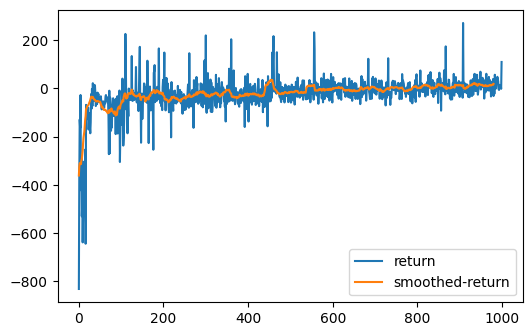

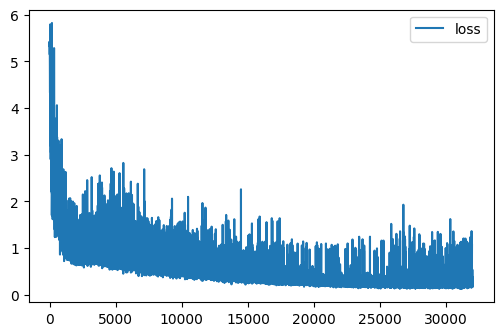

In [27]:
plot_training(stats, losses)

In [28]:
# Display trained agent's performance
env = gym.make("LunarLander-v3", render_mode='human')

display_env(q_agent, env)
env.close()

Total reward: 35.73904984182079


### DQN with Target Network

#### Pendulum

In [ ]:
env, ac_space, o_space = create_env("Pendulum-v1")

q_agent = TargetDQNAgent(
    o_space,
    ac_space,
    discount=0.95,
    eps=0.2,
    update_target_every=20,
    tau=1e-3,
    use_torch=True
)

stats, losses = train_dqn_torch(q_agent, env, max_episodes=1000, max_steps=500, print_freq=100)

env.close()

Env. action space:
Discrete(5)
Env. observation space:
Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
Cuda availability: True
Training on device: cuda


  0%|          | 0/1000 [00:00<?, ?it/s]

1: Done after 500 steps. Reward: -3260.060900231634
101: Done after 500 steps. Reward: -2999.3631833957575
201: Done after 500 steps. Reward: -2177.9080875458067
301: Done after 500 steps. Reward: -135.6308314371631
401: Done after 500 steps. Reward: -538.1401196212092
501: Done after 500 steps. Reward: -128.70367393105838
601: Done after 500 steps. Reward: -389.46372482699473
701: Done after 500 steps. Reward: -142.49281768656172
801: Done after 500 steps. Reward: -520.2425340845784
901: Done after 500 steps. Reward: -644.7200591745844


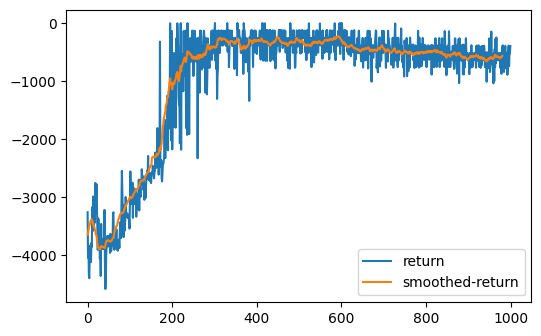

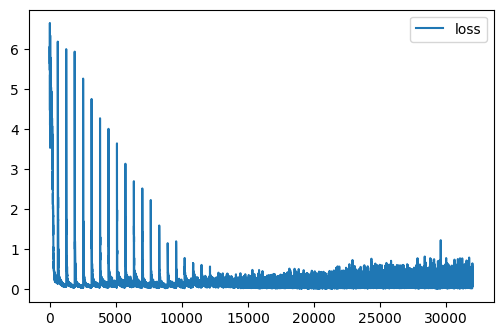

In [30]:
plot_training(stats, losses)

In [31]:
# Display trained agent's performance
env = gym.make("Pendulum-v1", render_mode='human')

display_env(q_agent, env)
env.close()

Total reward: -260.2637934893514


#### LunarLander

In [ ]:
env, ac_space, o_space = create_env("LunarLander-v3")

q_agent = TargetDQNAgent(
    o_space,
    ac_space,
    discount=0.95,
    eps=0.2,
    update_target_every=20,
    tau=1e-3,
    use_torch=True
)

stats, losses = train_dqn_torch(q_agent, env, max_episodes=1000, max_steps=600, print_freq=100)

env.close()

Env. action space:
Discrete(4)
Env. observation space:
Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Cuda availability: True
Training on device: cuda


  0%|          | 0/1000 [00:00<?, ?it/s]

1: Done after 78 steps. Reward: -337.83880065151095
101: Done after 255 steps. Reward: -69.2961402748771
201: Done after 177 steps. Reward: -72.96342829531284
301: Done after 600 steps. Reward: 139.84511507804706
401: Done after 600 steps. Reward: 35.45735209248022
501: Done after 600 steps. Reward: -3.35433239738217
601: Done after 600 steps. Reward: -15.961569307608613
701: Done after 600 steps. Reward: -9.62941339314336
801: Done after 600 steps. Reward: -37.152827985563505
901: Done after 600 steps. Reward: -23.939013821514223


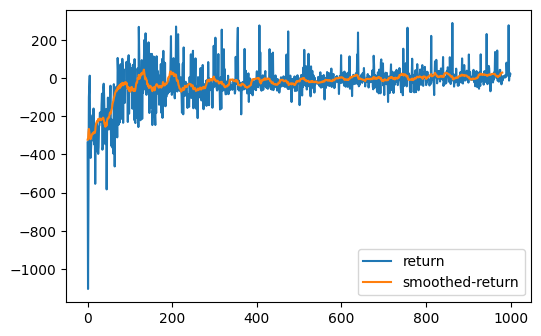

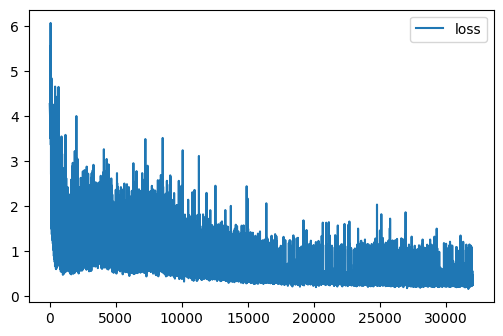

In [33]:
plot_training(stats, losses)

In [34]:
# Display trained agent's performance
env = gym.make("LunarLander-v3", render_mode='human')

display_env(q_agent, env)
env.close()

Total reward: 97.48367305778685


### Double DQN

#### Pendulum

In [ ]:
env, ac_space, o_space = create_env("Pendulum-v1")

q_agent = DoubleDQNAgent(
    o_space,
    ac_space,
    discount=0.95,
    eps=0.2,
    update_target_every=20,
    tau=1e-3,
    use_torch=True
)

stats, losses = train_dqn_torch(q_agent, env, max_episodes=1000, max_steps=500, print_freq=100)

env.close()

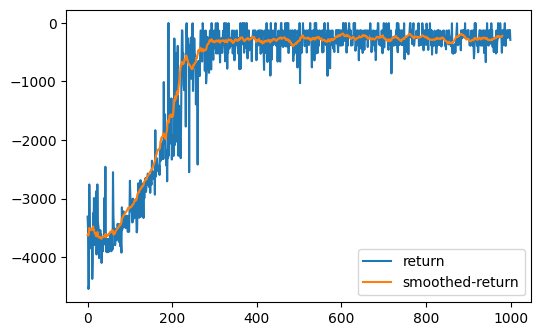

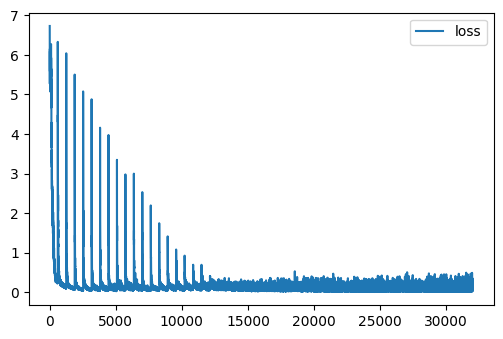

In [36]:
plot_training(stats, losses)

In [37]:
# Display trained agent's performance
env = gym.make("Pendulum-v1", render_mode='human')

display_env(q_agent, env)
env.close()

Total reward: -250.5996437122692


#### LunarLander

In [ ]:
env, ac_space, o_space = create_env("LunarLander-v3")

q_agent = DoubleDQNAgent(
    o_space,
    ac_space,
    discount=0.95,
    eps=0.2,
    update_target_every=20,
    tau=1e-3,
    use_torch=True
)

stats, losses = train_dqn_torch(q_agent, env, max_episodes=1000, max_steps=600, print_freq=100)

env.close()

Env. action space:
Discrete(4)
Env. observation space:
Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Cuda availability: True
Training on device: cuda


  0%|          | 0/1000 [00:00<?, ?it/s]

1: Done after 70 steps. Reward: -141.72017931660827
101: Done after 600 steps. Reward: 166.89492090263468
201: Done after 335 steps. Reward: -58.66157133498279
301: Done after 600 steps. Reward: -24.087744404822438
401: Done after 549 steps. Reward: -50.31976953554427
501: Done after 282 steps. Reward: -68.5351193687909
601: Done after 600 steps. Reward: 0.41752471016133863
701: Done after 600 steps. Reward: -16.37544782500152
801: Done after 600 steps. Reward: 8.148660447150549
901: Done after 187 steps. Reward: -63.056164672009395


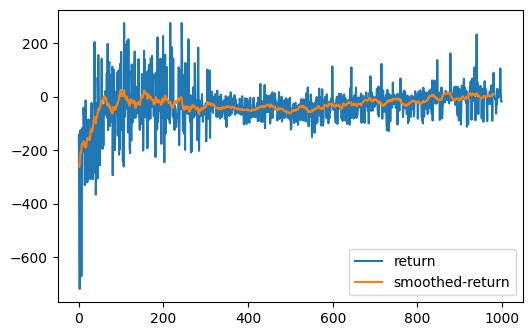

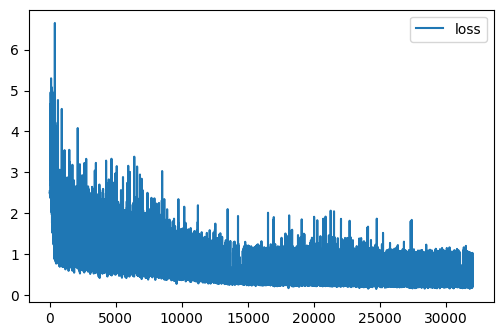

In [39]:
plot_training(stats, losses)

In [40]:
# Display trained agent's performance
env = gym.make("LunarLander-v3", render_mode='human')

display_env(q_agent, env)
env.close()

Total reward: 17.13284144305483


### Dueling DQN

#### Pendulum

In [3]:
env, ac_space, o_space = create_env("Pendulum-v1")

q_agent = DuelingDQNAgent(
    o_space,
    ac_space,
    discount=0.95,
    eps=0.2,
    update_target_every=20,
    tau=1e-3,
    use_torch=True
)

stats, losses = train_dqn_torch(q_agent, env, max_episodes=1000, max_steps=500, print_freq=100)

env.close()

Env. action space:
Discrete(5)
Env. observation space:
Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
Cuda availability: True
Training on device: cuda


  0%|          | 0/1000 [00:00<?, ?it/s]

1: Done after 500 steps. Reward: -3990.9674785691886
101: Done after 500 steps. Reward: -3206.4225379166623
201: Done after 500 steps. Reward: -138.1259968713796
301: Done after 500 steps. Reward: -393.896691969898
401: Done after 500 steps. Reward: -139.21851626832205
501: Done after 500 steps. Reward: -518.3452414078948
601: Done after 500 steps. Reward: -520.4791294160245
701: Done after 500 steps. Reward: -253.78653556759213
801: Done after 500 steps. Reward: -270.88233294260834
901: Done after 500 steps. Reward: -921.7784001524534


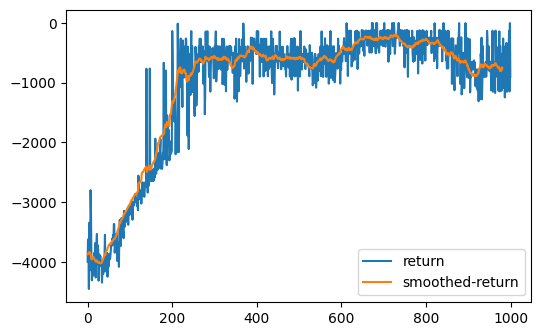

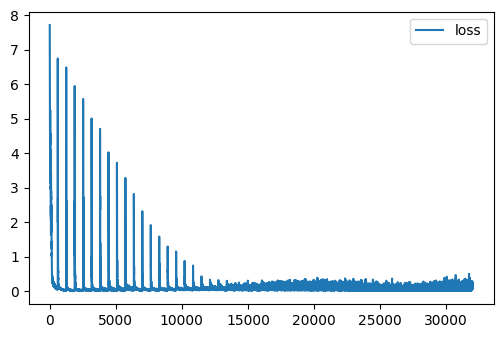

In [4]:
plot_training(stats, losses)

In [5]:
# Display trained agent's performance
env = gym.make("Pendulum-v1", render_mode='human')

display_env(q_agent, env)
env.close()

Total reward: -367.8692170511754


#### LunarLander

In [6]:
env, ac_space, o_space = create_env("LunarLander-v3")

q_agent = DuelingDQNAgent(
    o_space,
    ac_space,
    discount=0.95,
    eps=0.2,
    update_target_every=20,
    tau=1e-3,
    use_torch=True
)

stats, losses = train_dqn_torch(q_agent, env, max_episodes=1000, max_steps=600, print_freq=100)

env.close()

Env. action space:
Discrete(4)
Env. observation space:
Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Cuda availability: True
Training on device: cuda


  0%|          | 0/1000 [00:00<?, ?it/s]

1: Done after 70 steps. Reward: -461.73917465874587
101: Done after 257 steps. Reward: -99.84998469232669
201: Done after 253 steps. Reward: -42.53216428553189
301: Done after 600 steps. Reward: 94.95277671794632
401: Done after 600 steps. Reward: 1.4702912192370101
501: Done after 188 steps. Reward: -104.25881638129465
601: Done after 600 steps. Reward: -10.658518297034945
701: Done after 173 steps. Reward: -89.8478119234995
801: Done after 600 steps. Reward: 53.017889569535
901: Done after 600 steps. Reward: -27.720100458581175


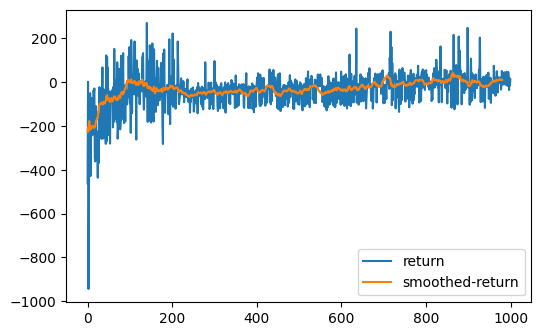

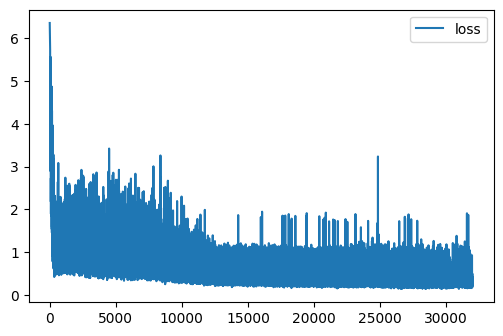

In [7]:
plot_training(stats, losses)

In [8]:
# Display trained agent's performance
env = gym.make("LunarLander-v3", render_mode='human')

display_env(q_agent, env)
env.close()

Total reward: -4.79220440917136


### Double Dueling DQN

#### Pendulum

In [9]:
env, ac_space, o_space = create_env("Pendulum-v1")

q_agent = DoubleDuelingDQNAgent(
    o_space,
    ac_space,
    discount=0.95,
    eps=0.2,
    update_target_every=20,
    tau=1e-3,
    use_torch=True
)

stats, losses = train_dqn_torch(q_agent, env, max_episodes=1000, max_steps=500, print_freq=100)

env.close()

Env. action space:
Discrete(5)
Env. observation space:
Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
Cuda availability: True
Training on device: cuda


  0%|          | 0/1000 [00:00<?, ?it/s]

1: Done after 500 steps. Reward: -3832.7017232671406
101: Done after 500 steps. Reward: -3369.6014487818256
201: Done after 500 steps. Reward: -136.13933146735047
301: Done after 500 steps. Reward: -137.65628737336334
401: Done after 500 steps. Reward: -136.40299192874295
501: Done after 500 steps. Reward: -134.65086497703993
601: Done after 500 steps. Reward: -540.487145405338
701: Done after 500 steps. Reward: -126.07932228639785
801: Done after 500 steps. Reward: -772.8294541750079
901: Done after 500 steps. Reward: -135.25969265502917


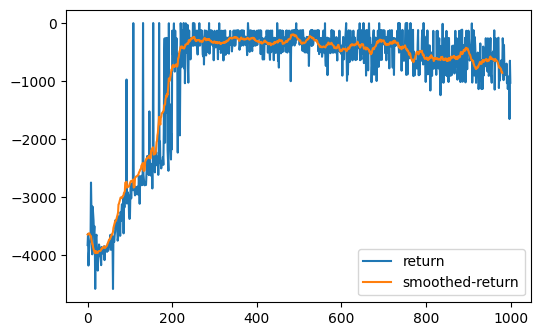

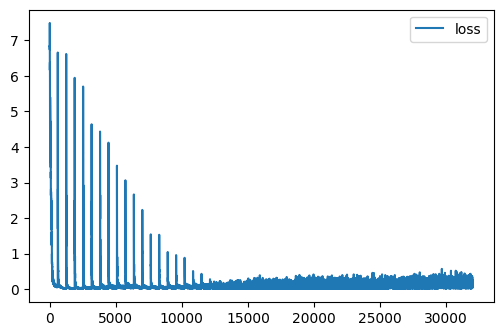

In [10]:
plot_training(stats, losses)

In [11]:
# Display trained agent's performance
env = gym.make("Pendulum-v1", render_mode='human')

display_env(q_agent, env)
env.close()

Total reward: -261.8006786041809


#### LunarLander

In [12]:
env, ac_space, o_space = create_env("LunarLander-v3")

q_agent = DoubleDuelingDQNAgent(
    o_space,
    ac_space,
    discount=0.95,
    eps=0.2,
    update_target_every=20,
    tau=1e-3,
    use_torch=True
)

stats, losses = train_dqn_torch(q_agent, env, max_episodes=1000, max_steps=600, print_freq=100)

env.close()

Env. action space:
Discrete(4)
Env. observation space:
Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Cuda availability: True
Training on device: cuda


  0%|          | 0/1000 [00:00<?, ?it/s]

1: Done after 86 steps. Reward: -180.75779544221967
101: Done after 218 steps. Reward: -253.6975478776618
201: Done after 301 steps. Reward: 2.6623525176305236
301: Done after 600 steps. Reward: -3.4228240846970106
401: Done after 600 steps. Reward: -2.283191651051001
501: Done after 600 steps. Reward: 27.86648338640382
601: Done after 174 steps. Reward: -97.45295392076488
701: Done after 600 steps. Reward: 3.7270038332214215
801: Done after 482 steps. Reward: -104.44371088813466
901: Done after 600 steps. Reward: 1.3065825447207542


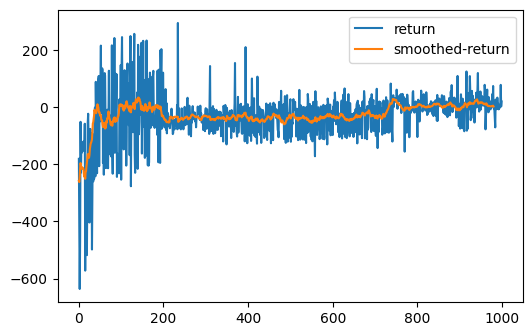

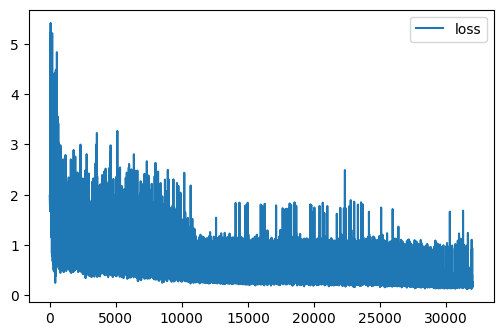

In [13]:
plot_training(stats, losses)

In [15]:
# Display trained agent's performance
env = gym.make("LunarLander-v3", render_mode='human')

display_env(q_agent, env)
env.close()

Total reward: 5.184530374441225
